In [70]:
using Agents
using WebIO
using Interact
using InteractiveDynamics
using GLMakie
using CairoMakie
using Statistics
using Plots
using StatsBase

In [71]:
generate_payouts(R, T, S, P) = Dict(
    (:C, :C) => R, # reward
    (:C, :D) => S, # sucker
    (:D, :C) => T, # temptation
    (:D, :D) => P) # punishment


generate_payouts (generic function with 1 method)

In [95]:
@agent Player GridAgent{2} begin
    strat::Symbol
    old_strat::Symbol
    update_type::Symbol
    mutation::Float64
end

In [96]:
a = Player(1, (1,1), :C, :C, :prob_imitator, 0.0)

Player(1, (1, 1), :C, :C, :prob_imitator, 0.0)

In [104]:
@agent Player GridAgent{2} begin
    strat::Symbol
    old_strat::Symbol
    update_type::Symbol
    mutation::Float64
end

function average_payout(player::Player, model::ABM)
    neighbors = nearby_agents(player, model)
    neighbor_payouts = [model.game[player.strat, n.strat] for n in neighbors]
    return mean(neighbor_payouts)
end

function total_payout(player::Player, model::ABM)
    neighbors = nearby_agents(player, model)
    neighbor_payouts = [model.game[player.strat, n.strat] for n in neighbors]
    return sum(neighbor_payouts)
end

function update!(player::Player, model::ABM)
    neighbors = collect(nearby_agents(player, model))

    if player.update_type == :imitate
        # Imitate the strategy of the neighbor with the highest payout
        payouts = [total_payout(n, model) for n in neighbors]
        max_payout = maximum(payouts)
        max_payout_neighbors = neighbors[payouts .== max_payout]
        player.old_strat = player.strat
        player.strat = rand(model.rng, max_payout_neighbors).strat

    elseif player.update_type == :prob_imitator
        payouts = [average_payouts(n, model) for n in neighbors]
        total_avg = sum(payouts)
        probs = payouts ./ total_avg
        player.old_strat = player.strat
        player.strat = sample(model.rng, neighbors, Weights(probs), 1)[1].strat
    
    end

    if rand(model.rng) < player.mutation
        player.strat = rand(model.rng, model.strats)
    end
end



update! (generic function with 1 method)

In [73]:
x = [1, 2, 3, 4]

x[x .>= 3]

2-element Vector{Int64}:
 3
 4

In [74]:
using Random # for reproducibility

function initialize(game::Any; 
    dims = (2,2), 
    bias_C::Float64 = 0.5,
    mutation::Float64 = 0.0,
    update_type::Symbol = :imitate,
    strats = [:C, :D],
    seed = 42)

    space = GridSpaceSingle(dims, periodic = false)
    
    rng = Random.Xoshiro(seed)

    properties = Dict(
        :game => game, 
        :strats => strats
    )
    model = UnremovableABM(
        Player, space;
        properties,
        rng, scheduler = Schedulers.Randomly()
    )
    # populate the model with agents
    
    for (i, cell) in enumerate(positions(space))
        strat = rand(rng) < bias_C ? :C : :D
        player = Player(
            i,
            cell, 
            strat, 
            strat,
            update_type,
            mutation)
        add_agent!(player, cell, model)
    end
    return model
end



initialize (generic function with 1 method)

In [75]:
model = initialize(pd; dims=(5,5), seed=nothing)
#for a in model.agents
#    println("Agent: ", a)
#end

println(model.space)
for i in 1:10
    a = random_agent(model)
    println(a.pos)
    println([b.pos for b in collect(nearby_agents(a, model))])
end

GridSpaceSingle with size (5, 5), metric=chebyshev, periodic=false
(2, 3)


[(1, 2), (2, 2), (3, 2), (1, 3), (3, 3), (1, 4), (2, 4), (3, 4)]
(2, 2)
[(1, 1), (2, 1), (3, 1), (1, 2), (3, 2), (1, 3), (2, 3), (3, 3)]
(2, 1)
[(1, 1), (3, 1), (1, 2), (2, 2), (3, 2)]
(3, 4)
[(2, 3), (3, 3), (4, 3), (2, 4), (4, 4), (2, 5), (3, 5), (4, 5)]
(2, 3)
[(1, 2), (2, 2), (3, 2), (1, 3), (3, 3), (1, 4), (2, 4), (3, 4)]
(3, 3)
[(2, 2), (3, 2), (4, 2), (2, 3), (4, 3), (2, 4), (3, 4), (4, 4)]
(3, 5)
[(2, 4), (3, 4), (4, 4), (2, 5), (4, 5)]
(1, 5)
[(1, 4), (2, 4), (2, 5)]
(2, 2)
[(1, 1), (2, 1), (3, 1), (1, 2), (3, 2), (1, 3), (2, 3), (3, 3)]
(2, 4)
[(1, 3), (2, 3), (3, 3), (1, 4), (3, 4), (1, 5), (2, 5), (3, 5)]


In [76]:
function model_step!(model)

    # Choose a random agent
    player = random_agent(model)
    update!(player, model)
end



model_step! (generic function with 1 method)

In [77]:
pd = generate_payouts(3, 4, 0, 1)
println(pd)
model = initialize(pd; dims=(10,10))

println(model.game[:C, :D])

Dict((:D, :D) => 1, (:C, :D) => 0, (:C, :C) => 3, (:D, :C) => 4)
0


Dict((:D, :D) => 1, (:C, :D) => 0, (:C, :C) => 3, (:D, :C) => 4)


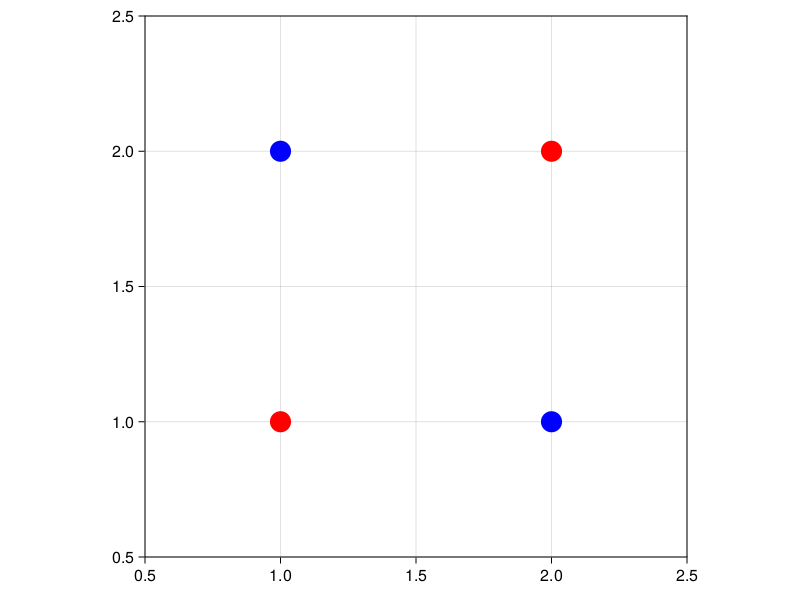

In [79]:
pd = generate_payouts(3, 4, 0, 1)
println(pd)
model = initialize(pd; dims=(2, 2), seed=42)

strats_to_colors = Dict(
    (:C, :C) => :blue,
    (:D, :D) => :red,
    (:C, :D) => :green,
    (:D, :C) => :orange
)
# Function to choose color based on agent's strategy
player_strategy_color(player) = strats_to_colors[player.strat, player.old_strat]

# Plot the model

fig, _ = InteractiveDynamics.abmplot(model; ac = player_strategy_color,  as = 30)
fig


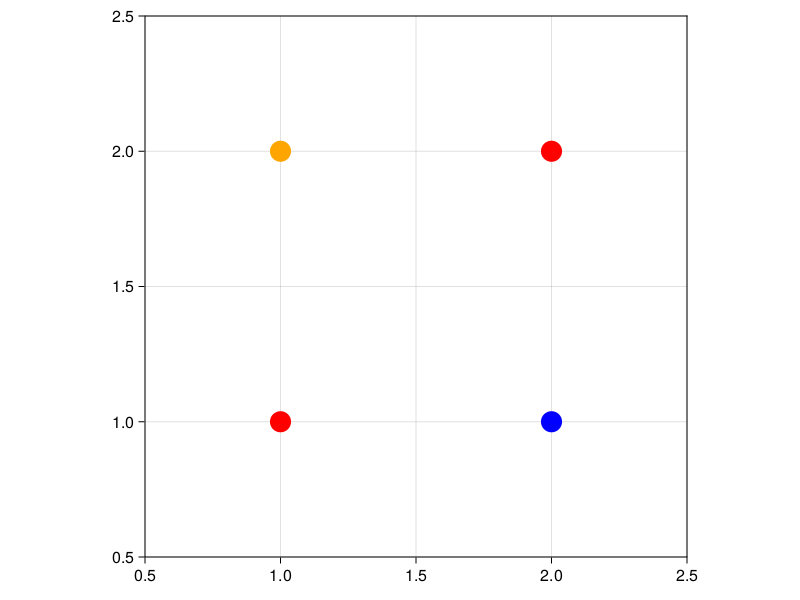

In [80]:
step!(model, dummystep, model_step!, 1)
fig, _ = InteractiveDynamics.abmplot(model; ac = player_strategy_color,  as = 30)
fig


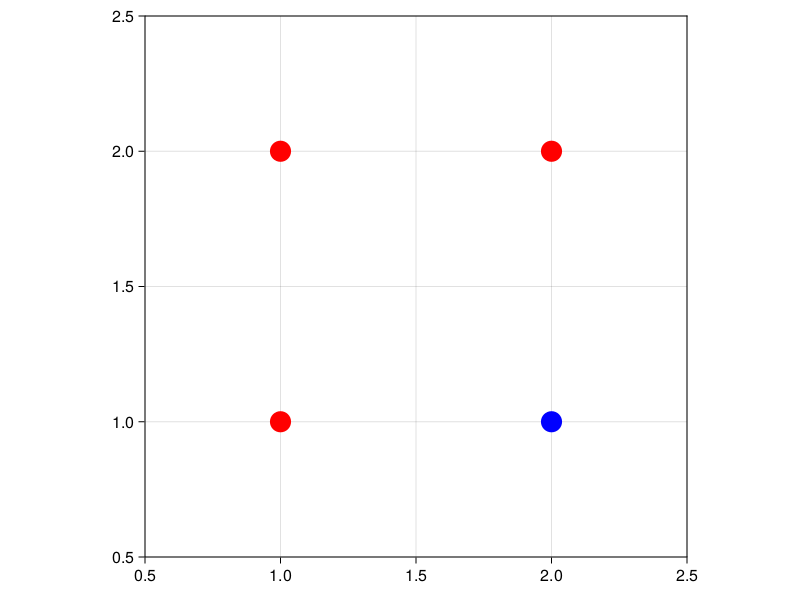

In [81]:
step!(model, dummystep, model_step!, 1)
fig, _ = InteractiveDynamics.abmplot(model; ac = player_strategy_color,  as = 30)
fig


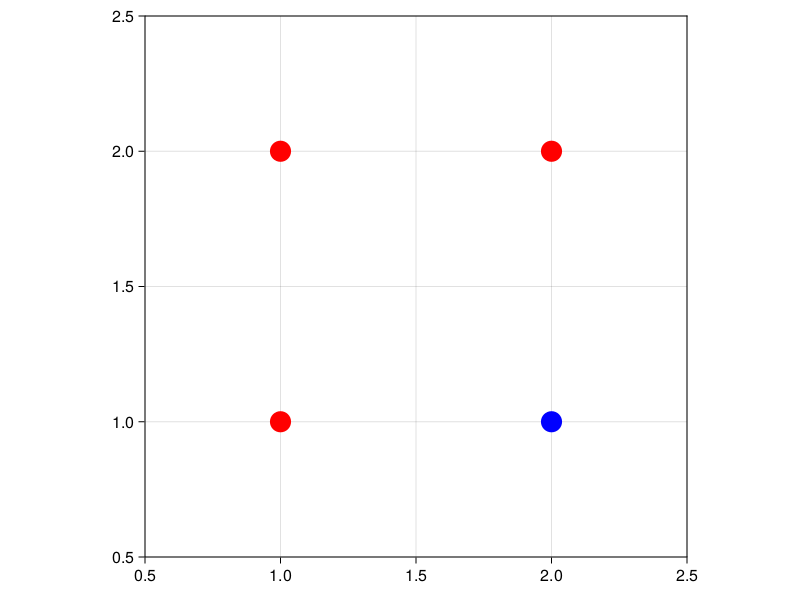

In [82]:
step!(model, dummystep, model_step!, 1)
fig, _ = InteractiveDynamics.abmplot(model; ac = player_strategy_color, as=30)
fig

In [91]:

sh = generate_payouts(3, 2, 0, 1)
chicken = generate_payouts(2, 3, 1, 0)
coop = generate_payouts(1, 0, 0, 1)
pd = generate_payouts(3, 4, 0, 1)

model = initialize(coop; dims=(10,10), seed=0, mutation=0.0)

InteractiveDynamics.abmvideo(
    "latticegames_coop.mp4", model, dummystep, model_step!;
    ac = player_strategy_color, as = 30,
    framerate = 100, frames = 5000,
    title = "Lattice Games - Cooperation"
)


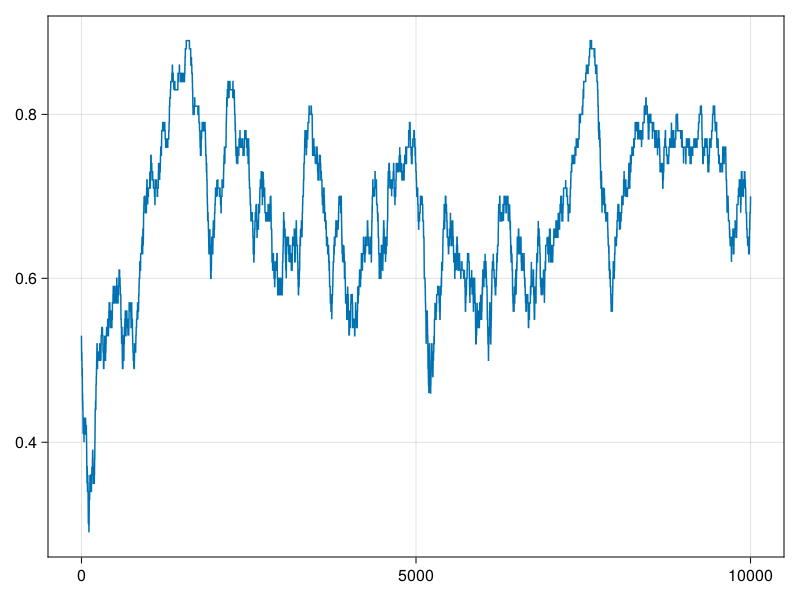

In [84]:
adata = [:strat]

avg_coop(model) = sum([1 for a in model.agents if a.strat == :C])/length(model.agents)

mdata = [avg_coop]

model = initialize(chicken; dims=(10,10), mutation=0.01)
adf, mdf = run!(model, dummystep, model_step!, 10000; adata, mdata)
mdf # print only a few rows

lines(
    mdf.step, 
    mdf.avg_coop, 
    title="Average Cooperation", 
    xlabel="Time", 
    ylabel="Cooperation")


In [94]:
num_sims = 20

adata = [:strat]

avg_coop(model) = sum([1 for a in model.agents if a.strat == :C])/length(model.agents)

mdata = [avg_coop]

perc_coops = []
for s in 1:num_sims
    model = initialize(coop; dims=(100,100), mutation=0.00, seed=s)
    df, mdf = run!(model, dummystep, model_step!, 100000; adata, mdata)
    #println(mdf.avg_coop)
    push!(perc_coops, mdf.avg_coop)
    if mdf.avg_coop[end] > 0.1
        println(s)
    end
end

Plots.plot(perc_coops, legend=false, title="Average Cooperation", xlabel="Step", ylabel="Percent cooperators", ylims=(0,1))
savefig("coop_lattice_game.pdf")

#p

1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


"/Users/epacuit/Dropbox/teaching/esslli/esslli2023-game-theory-julia/simulations/chicken_lattice_game.pdf"

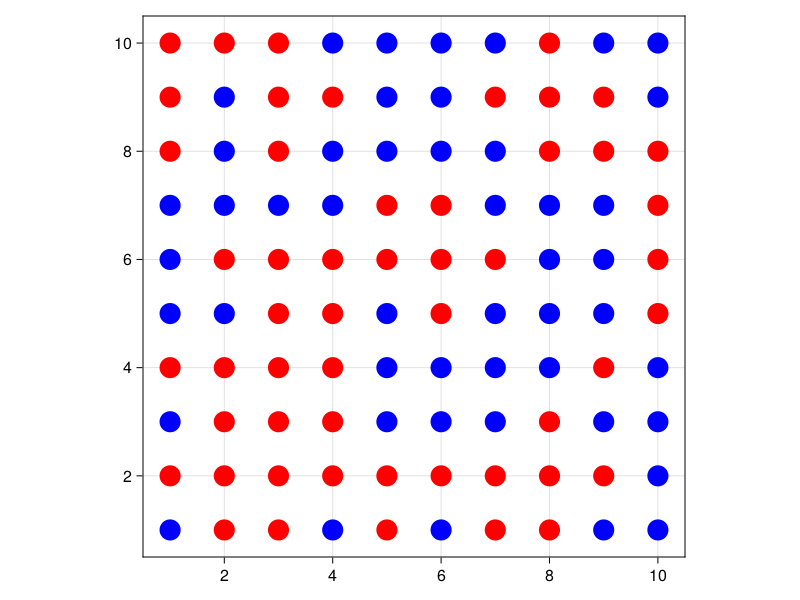

In [86]:
model = initialize(pd; dims=(10,10), mutation=0.00, seed=7)
fig, _ = InteractiveDynamics.abmplot(model; ac = player_strategy_color, as=30)
fig

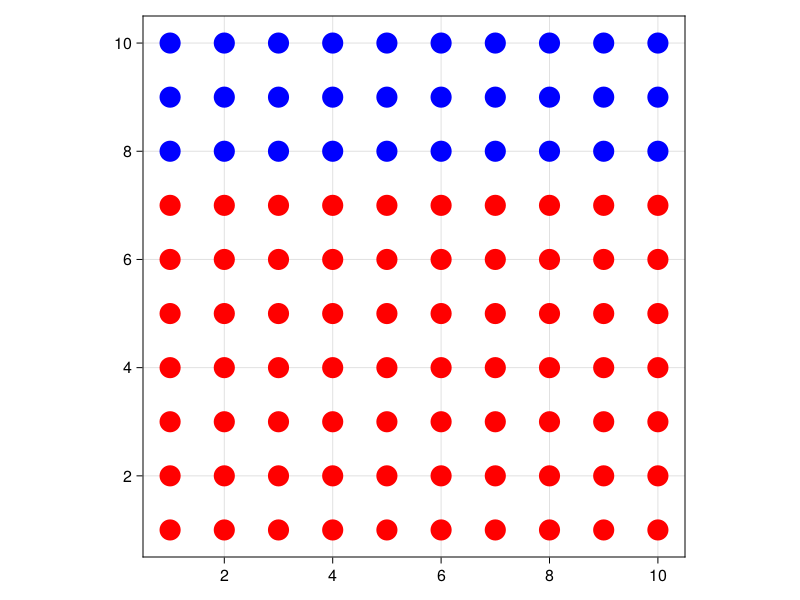

In [57]:
step!(model, dummystep, model_step!, 500)
fig, _ = InteractiveDynamics.abmplot(model; ac = player_strategy_color, as=30)
fig

In [58]:
cooperators = [a for a in model.agents if a.strat == :C]
println(cooperators)

Player[Player(71, (1, 8), :C, :C, :imitate, 0.0), Player(72, (2, 8), :C, :C, :imitate, 0.0), Player(73, (3, 8), :C, :C, :imitate, 0.0), Player(74, (4, 8), :C, :C, :imitate, 0.0), Player(75, (5, 8), :C, :C, :imitate, 0.0), Player(76, (6, 8), :C, :C, :imitate, 0.0), Player(77, (7, 8), :C, :C, :imitate, 0.0), Player(78, (8, 8), :C, :C, :imitate, 0.0), Player(79, (9, 8), :C, :C, :imitate, 0.0), Player(80, (10, 8), :C, :C, :imitate, 0.0), Player(81, (1, 9), :C, :C, :imitate, 0.0), Player(82, (2, 9), :C, :C, :imitate, 0.0), Player(83, (3, 9), :C, :C, :imitate, 0.0), Player(84, (4, 9), :C, :C, :imitate, 0.0), Player(85, (5, 9), :C, :C, :imitate, 0.0), Player(86, (6, 9), :C, :C, :imitate, 0.0), Player(87, (7, 9), :C, :C, :imitate, 0.0), Player(88, (8, 9), :C, :C, :imitate, 0.0), Player(89, (9, 9), :C, :C, :imitate, 0.0), Player(90, (10, 9), :C, :C, :imitate, 0.0), Player(91, (1, 10), :C, :C, :imitate, 0.0), Player(92, (2, 10), :C, :C, :imitate, 0.0), Player(93, (3, 10), :C, :C, :imitate, 0.0),

In [64]:
a_coop = cooperators[1]

update!(a_coop, model)

println(a_coop)

nbhs = collect(nearby_agents(a_coop, model))

for n in nbhs
    println(n)
    println(total_payout(n, model))
end


Player(71, (1, 8), :C, :C, :imitate, 0.0)
Player(61, (1, 7), :D, :D, :imitate, 0.0)
11
Player(62, (2, 7), :D, :D, :imitate, 0.0)
17
Player(72, (2, 8), :C, :C, :imitate, 0.0)
15
Player(81, (1, 9), :C, :C, :imitate, 0.0)
15
Player(82, (2, 9), :C, :C, :imitate, 0.0)
24
